In [7]:
import numpy as np
import pandas as pd
#可視化
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [8]:
train = pd.read_csv('/Users/bella/titanic/train.csv')
test = pd.read_csv('/Users/bella/titanic/test.csv')
combine = pd.concat([train,test])

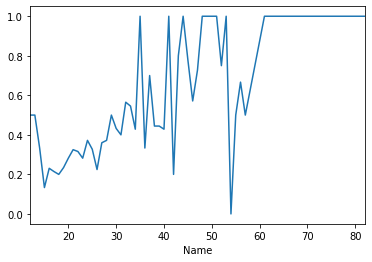

In [9]:
train.groupby(train.Name.apply(lambda x: len(x)))['Survived'].mean().plot()

In [10]:
combine['Name_Len'] = combine['Name'].apply(lambda x :len(x))
combine['Name_Len'] = pd.qcut(combine['Name_Len'], 5)

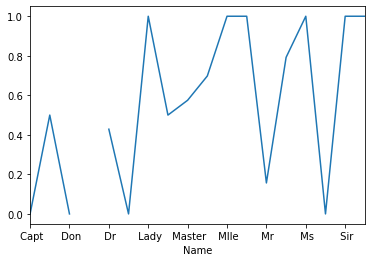

In [11]:
combine.groupby(combine['Name'].apply(lambda x : x.split(',')[1]).apply(lambda x: x.split('.')[0]))['Survived'].mean().plot()

In [12]:
combine['Title'] = combine['Name'].apply(lambda x : x.split(',')[1]).apply(lambda x : x.split('.')[0])
combine['Title'] = combine['Name'].replace(['Don','Dona' ,'Majoy', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir'], 'Mr')
combine['Title'] = combine['Name'].replace(['Mlle','Ms'], 'Miss')
combine['Title'] = combine['Name'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
df = pd.get_dummies(combine['Title'],prefix='Title')
combine = pd.concat([combine, df], axis=1)

In [13]:
combine['Fname'] = combine['Name'].apply(lambda x:x.split(',')[0])
combine['FamilySize'] = combine['SibSp'] + combine['Parch']
dead_female_Fname = list(set(combine[(combine.Sex=='female') & (combine.Age>=12)
                        & (combine.Survived==0) & (combine.FamilySize>1)]['Fname'].values))
alive_male_Fname = list(set(combine[(combine.Sex=='male') & (combine.Age>=12) 
                        & (combine.Survived==1) & (combine.FamilySize>1)]['Fname'].values))
combine['Female_Dead_Family'] = np.where(combine['Fname'].isin(dead_female_Fname),1,0)
combine['Male_Alive_Family'] = np.where(combine['Fname'].isin(alive_male_Fname),1,0)
combine = combine.drop(['Name', 'Fname'], axis=1)

In [14]:
group = combine.groupby(['Title', 'Pclass'])['Age']
combine['Age'] = group.transform(lambda x : x.fillna(x.median()))
combine = combine.drop('Title', axis=1)

combine['Child'] = np.where(combine['Age'] <=12 ,1,0)
combine['Age'] = pd.cut(combine['Age'], 5)
combine = combine.drop('Age', axis=1)

In [15]:
df = pd.get_dummies(combine['FamilySize'],prefix='FamilySize')
combine = pd.concat([combine ,df],axis=1)
combine = combine.drop(['SibSp', 'Parch', 'FamilySize'],axis=1)

In [16]:
combine['Ticket_Lett'] = combine['Ticket'].apply(lambda x : str(x)[0])
combine['Ticket_Lett'] = combine['Ticket_Lett'].apply(lambda x :str(x))
combine['High_Survival_Ticket'] = np.where(combine['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
combine['Low_Survival_Ticket'] = np.where(combine['Ticket_Lett'].isin(['A', 'W', '3', '7']),1,0)
combine = combine.drop(['Ticket', 'Ticket_Lett'], axis=1)

In [17]:
combine.Embarked = combine.Embarked.fillna('S')
df = pd.get_dummies(combine['Embarked'],prefix='Embarked')
combine = pd.concat([combine, df],axis=1)
combine = combine.drop('Embarked', axis=1)

In [18]:
combine['Cabin_isNull'] = np.where(combine['Cabin'].isnull(),0,1)
combine = combine.drop('Cabin', axis=1)

In [19]:
df = pd.get_dummies(combine['Pclass'],prefix='Pclass')
combine = pd.concat([combine, df], axis=1).drop('Pclass',axis=1)

In [20]:
df = pd.get_dummies(combine['Sex'], prefix='Pclass')
combine = pd.concat([combine, df], axis=1).drop('Sex',axis=1)

In [21]:
combine['Fare'] = pd.qcut(combine.Fare,3)
df = pd.get_dummies(combine.Fare,prefix='Fare').drop('Fare_(-0.001, 8.662]', axis=1)
combine = pd.concat([combine, df], axis=1).drop('Fare', axis=1)

In [22]:
features = combine.drop(['PassengerId', 'Survived'],axis=1).columns
le = LabelEncoder()
for feature in features:
    le = le.fit(combine[feature])
    combine[feature] = le.transform(combine[feature])

In [23]:
X_all = combine.iloc[:891, :].drop(['PassengerId', 'Survived'], axis=1)
Y_all = combine.iloc[:891, :]['Survived']
X_test = combine.iloc[:891, :].drop(['PassengerId', 'Survived'], axis=1)

In [34]:
lg = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=300, min_samples_leaf=4, class_weight={0:0.745 ,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500, learning_rate=0.03, max_depth=3)
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
clfs = [lg, svc, knn, dt, rf, gbdt, xgb]

kfold = 10
cv_results = []
for classifier in clfs :
    cv_results.append(cross_val_score(classifier, X_all, y = Y_all, scoring = "accuracy", cv = kfold , n_jobs=4))

    
cv_means = []
cv_stds = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_stds.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValErrors":cv_stds,
                      "Algorithm":["LR","SVC","KNN","DT","RF","GBDT","XGB"]})
g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3", orient = "h",**{'xerr:cv_std'})
g.set_xlabel("Mean Accuracy")


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}